In [12]:
# import libraries for class
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import time

# sklearn models
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, TweedieRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor 
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [13]:
class full_regression:
    """A class which automatically does many regression models and gridsearches for you. 
    Note: when you run a new model it will overwrite the previous model. You can access the current model with .model and .model_des.
    Other options:
    run_all = default True, if set to false the class will not automatically run any models
    standardize = default True, uses standard scaler and fit-transforms on train, transform on test if exists
    test_size = default 0.15, decide the side of your test set - set to 0 if dont want test
    folds = default 6, amount of folds for cross validation - integer > 1
    shuffle = default True, shuffle the data for test split and cross val
    stratify = default None, input the variable that you which to stratify the data by
    print_info = default True, print all of the results out every time you run a model
    save_it = default False, this adds functionality to be able to save down all model results into a
              dataframe, set as a global variable called model_tracker.
    comment = default None, This is a comment field for the model_tracker
    Go to readme for further information: https://github.com/LukeBetham/machine-learning-classes/blob/master/README.md
    Created by LukeBetham"""

    def __init__(self, X, y, run_all=True, standardize=True,
                 test_size=0.15, folds=6, shuffle=True, stratify=None,
                 print_info=True, save_it=False, comment=None):
        # Save settings to object
        self.folds = folds
        self.shuffle = shuffle
        self.stratify= stratify
        self.comment = comment
        self.save_it = save_it
        self.print_info = print_info
        if self.stratify is None:
            self.kfold = KFold(self.folds, shuffle=self.shuffle, random_state=66)
        else:
            self.kfold = StratifiedKFold(self.folds, shuffle=self.shuffle, random_state=66)
        # Option for bolding print text
        self.BOLD = '\033[1m'
        self.END = '\033[0m'
        # Create train-test split if selected
        self.X = X
        self.y = y
        self.test = test_size
        if self.test != 0:
            self.X, self.X_test, self.y, self.y_test, self.index_train, self.index_test = train_test_split(
                self.X, self.y, self.X.index, test_size=self.test, shuffle=self.shuffle, 
                stratify=self.stratify, random_state=66)
        # Standardise the data if selected
        if standardize == True:
            scaler = StandardScaler()
            self.X = pd.DataFrame(
                scaler.fit_transform(self.X), columns=self.X.columns)
            if self.test != 0:
                self.X_test = pd.DataFrame(
                    scaler.transform(self.X_test), columns=self.X.columns)
        # Run all models
        if run_all==True:
            self.Linear()
            self.Linear_elastic_net()
            self.Linear_generalised()
            self.SVM_regressor()
            self.KNN_regressor()
            self.Decision_tree_model()
            self.Random_forest_model()
            self.GradientBoosting()
            self.VotingRegressor()
            self.MLP_Neural_Net()

    def Linear(self, model=LinearRegression()):
        # Set up linear model
        self.model = model
        self.model_des = "Linear Regression Model"
        self.grid_multiple = 1
        self.model_calc()
        
    def Linear_elastic_net(self, model=ElasticNet()):
        # Set up linear model
        self.model = model
        self.model_des = "Linear Regression Model (with Elastic Net)"
        self.grid_multiple = 1
        self.model_calc()

    def Linear_generalised(self, model=TweedieRegressor()):
        # Set up linear model generalised - power=0: Normal, power = 1: Poisson, power = 2: Gamma, power = 3: Inverse Gaussian distribution.
        self.model = model
        self.model_des = "Generalised Linear Regression Model"
        self.grid_multiple = 1
        self.model_calc()
    
    def SVM_regressor(self, model=SVR()):
        # Set up SVM
        self.model = model
        self.model_des = "SVM Regression Model"
        self.grid_multiple = 1
        self.model_calc()
        
    def KNN_regressor(self, model=KNeighborsRegressor()):
        # Set up KNN 
        self.model = model
        self.model_des = "KNN Regression Model"
        self.grid_multiple = 1
        self.model_calc()
        
    def knn_all_k(self, limit = 50):
        # run KNN for all possible Ks and graph them
        self.scores = []
        self.max_k = np.minimum(limit,int(len(self.y)*(1-(1/self.folds))-1))
        for k in range(1, self.max_k):
            knn = KNeighborsRegressor(n_neighbors=k)
            self.scores.append(np.mean(cross_val_score(knn, self.X, self.y, cv=self.kfold)))
        self.knn_best = self.scores.index(np.max(self.scores))+1
        plt.plot(range(1, self.max_k), self.scores, label='Mean CV Scores')
        plt.xlabel('k')
        plt.ylabel('R2')
        plt.legend(loc=[1.1, 0])
        print(self.BOLD + "Highest KNN Score:" + self.END, self.knn_best)
        plt.show()
        
    def Decision_tree_model(self, print_tree=False, print_depth=5, model=DecisionTreeRegressor(random_state=66)):
        # set up decision tree model
        self.model = model
        self.model_des = "Decision Tree Model"
        self.grid_multiple = 1
        self.model_calc()
        if print_tree == True:
            dot_data = StringIO() 
            export_graphviz(self.model, out_file=dot_data, filled=True, rounded=True,
                            special_characters=True, feature_names=self.X.columns, max_depth=print_depth)  

            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            display(Image(graph.create_png()))

    def Random_forest_model(self, model=RandomForestRegressor(random_state=66)):
        self.model = model
        self.model_des = "Random Forest Model"
        self.grid_multiple = 1
        self.model_calc()
            
    def GradientBoosting(self, grad_model=GradientBoostingRegressor(random_state=66)):
        self.model = grad_model
        self.model_des = "Gradient Boosting Model"
        self.grid_multiple = 32.4
        self.model_calc()
    
    def VotingRegressor(self, model = VotingRegressor, vote_model1 = LinearRegression(), vote_model2 = RandomForestRegressor(random_state=66), vote_model3 = GradientBoostingRegressor(random_state=66)):
        reg1 = vote_model3
        reg2 = vote_model2
        reg3 = vote_model1
        self.model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
        self.model_des = "Voting Regressor Model (default Linear & RF & GB)"
        self.grid_multiple = 1
        self.model_calc()
    
    def MLP_Neural_Net(self, model = MLPRegressor(solver='adam', alpha=10**(0),
                                        hidden_layer_sizes=(10, 10, 10), activation='relu',
                                        random_state=66, batch_size=50,max_iter=500)):
        self.model = model
        self.model_des = 'MLP Regressor Neural Net'
        self.grid_multiple = 1
        self.model_calc()

    def model_calc(self):
        # fit model
        t0 = time.time()
        self.model.fit(self.X, self.y)
        self.sc = self.model.score(self.X, self.y)
        self.cvs = cross_val_score(self.model, self.X, self.y, cv=self.kfold).mean()
        self.rmse = -cross_val_score(self.model, self.X, self.y, cv=self.kfold, scoring="neg_root_mean_squared_error").mean()
        # Get test score
        if self.test != 0:
            self.sct = self.model.score(self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))
        else:
            self.sct = 'No Test Set'
            self.sctp = 'No Test Set'
        # time the running of the model
        t1 = time.time()
        self.elaspsed = t1-t0
        # show the results from the classification model
        if self.print_info==True:
            print(self.BOLD + self.model_des, 'Test\nTrain Score:' + self.END, round(self.sc, 4),
                  self.BOLD + '\nCV Fold Score (r^2):' +
                  self.END, round(self.cvs, 4),
                  self.BOLD + '\nCV Fold Score (RMSE):' +
                  self.END, round(self.rmse, 4),
                  self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*self.grid_multiple, 2), 'minutes to run.\n')
        try:
            self.coef = self.model.coef_
            self.coefs
        except:
            pass
        if self.save_it == True:
            self.tracking()
            
    def tracking(self):
        global model_tracker
        df_temp = pd.DataFrame({'model_type':self.model_des,'model_train_score':self.sc,
                                'cv_score_r2':self.cvs,'cv_score_rmse': self.rmse,'test_score':self.sct,'predictors': str(','.join(self.X.columns)),
                                'model_params':str(self.model),'observations':len(self.X),'time':self.elaspsed,'comment':self.comment},index=[1])
        try:
            model_tracker =  pd.concat([model_tracker,df_temp])
        except:
            model_tracker = pd.DataFrame(columns = ['model_type','model_train_score','cv_score_r2','cv_score_rmse',
                                                    'test_score','predictors','model_params','observations','time',
                                                    'comment'])
            model_tracker =  pd.concat([model_tracker,df_temp])

    def gridsearch(self, params='default'):
        """A function which automatically runs a gridsearch on your selected model. Returns model_grid model with best parameters.
        Has default parameters for each model type, but you can set your own by passing a dict into params = {}
        """
        # setting the default parameters if not set by user
        if params == 'default':
            if self.model_des == "Logistic Regression Model":
                self.params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
            elif self.model_des == "K Neighbors Model":
                self.params = {'n_neighbors': range(1, 20, 1), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
            elif self.model_des == "Decision Tree Model":
                self.params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': [
                    'best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, .01, .1, 1, 10, 100], 'class_weight': [None, 'balanced']}
            elif self.model_des == "Random Forest Model":
                self.params = {'n_estimators':[100,200,500], 'criterion':['gini','entropy'], 'max_depth':[None], 'min_samples_split':[2,6],"max_features":["auto","log2"],
                               'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha':[0.0,0.5,1]}
            elif self.model_des == "ADA Boosting Model": 
                self.params = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], 'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],
                               'algorithm':['SAMME'],"n_estimators":[100,200,500,1000]}
            elif self.model_des == "Gradient Boosting Model": 
                self.params = {"learning_rate": [0.01, 0.5, 1], 'loss':['deviance', 'exponential'],'max_features':['auto','log2','sqrt'],
                               'warm_start':[True,False],"n_estimators":[100,200], 'ccp_alpha':[0.0,0.5,0.9],'max_depth':[1,3,5], 'subsample':[1.0,0.75,0.5]}
            elif self.model_des == "Naive Bayes Model":
                self.params = {"var_smoothing": [0.000001, 0.2, 0.4, 0.6, 0.8, 1]}
            elif self.model_des == "Linear Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,20),'loss':['hinge','squared_hinge']}
            elif self.model_des == "Gaussian (rbf) Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'gamma':np.linspace(0.00001,100,15),'kernel':['rbf']}
            elif self.model_des == "Polynomial Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'coef0':[0,1,2,3,4,10],'kernel':['poly'],'degree':[2,3,4]}
            elif self.model_des == "MLP Classifier Neural Net": 
                self.params = {'solver':['adam','sgd'], 'alpha': np.linspace(0.00001,1,4),'hidden_layer_sizes':[(10, 10, 10,10),(20, 20, 20),(50,50),(100)],
                               'learning_rate' : ['constant', 'invscaling', 'adaptive'],'activation' : ['identity', 'logistic', 'tanh', 'relu']}
        else:
            self.params = params
        # setup the gridsearch
        self.grid = GridSearchCV(self.model, self.params, verbose=1, cv=StratifiedKFold(
            self.folds, shuffle=self.shuffle, random_state=66))
        self.grid.fit(self.X, self.y)
        self.gsc = self.grid.best_score_
        self.best = self.grid.best_params_
        self.model = self.grid.best_estimator_
        self.model_des = self.model_des + " Grid Search:"
        try:
            self.coef = self.grid.best_estimator_.coef_
        except:
            pass
        # Check test score for grid
        try:
            self.sct = self.grid.best_estimator_.score(
                self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))
        except:
            self.sctp = None
        # Print Grid results
        if self.print_info==True:
            print(self.BOLD + self.model_des + self.END)
            print(self.BOLD + "Best Mean CV Model Score:" + self.END, round(self.gsc, 4),
                  self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
            print(self.BOLD + 'Grid Best Parameters:\n' + self.END, self.best)
            print(self.BOLD + '\nSearch Parameters:\n' + self.END, self.params)
        self.coefs()

In [18]:
df = pd.read_csv("train_amended.csv")
model_tracker = pd.read_csv('model_tracker.csv')
y = df.pop("y")
# X = df.iloc[:,2:]
X = df.drop('galaxy',axis=1)

In [19]:
model_tracker

,model_type,model_train_score,cv_score_r2,cv_score_rmse,test_score,predictors,model_params,observations,time,comment
0,Linear Regression Model,0.900824,0.752000,0.041951,No Test Set,"existence expectancy index,existence expectanc...",LinearRegression(),334,0.082119,"First run with no nulls, no galaxy or year"
1,Linear Regression Model (with Elastic Net),0.000000,-0.003083,0.086114,No Test Set,"existence expectancy index,existence expectanc...",ElasticNet(),334,0.043729,"First run with no nulls, no galaxy or year"
2,Generalised Linear Regression Model,0.844314,0.817128,0.036760,No Test Set,"existence expectancy index,existence expectanc...",TweedieRegressor(),334,0.055200,"First run with no nulls, no galaxy or year"
3,SVM Regression Model,0.203636,0.086303,0.081352,No Test Set,"existence expectancy index,existence expectanc...",SVR(),334,0.052393,"First run with no nulls, no galaxy or year"
4,KNN Regression Model,0.933828,0.876282,0.030163,No Test Set,"existence expectancy index,existence expectanc...",KNeighborsRegressor(),334,0.086771,"First run with no nulls, no galaxy or year"
5,Decision Tree Model,1.000000,0.740263,0.043357,No Test Set,"existence expectancy index,existence expectanc...",DecisionTreeRegressor(random_state=66),334,0.096885,"First run with no nulls, no galaxy or year"
6,Random Forest Model,0.982509,0.869160,0.031106,No Test Set,"existence expectancy index,existence expectanc...",RandomForestRegressor(random_state=66),334,4.083646,"First run with no nulls, no galaxy or year"
7,Gradient Boosting Model,0.997897,0.867004,0.031362,No Test Set,"existence expectancy index,existence expectanc...",GradientBoostingRegressor(random_state=66),334,2.681762,"First run with no nulls, no galaxy or year"
8,Voting Regressor Model (default Linear & RF & GB),0.978455,0.866496,0.031350,No Test Set,"existence expectancy index,existence expectanc...","VotingRegressor(estimators=[('gb', GradientBoo...",334,7.255902,"First run with no nulls, no galaxy or year"
9,MLP Regressor Neural Net,0.738449,0.706093,0.046755,No Test Set,"existence expectancy index,existence expectanc...","MLPRegressor(alpha=1, batch_size=50, hidden_la...",334,7.084805,"First run with no nulls, no galaxy or year"


In [20]:
X

,galactic year,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",...,Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
0,990025,0.628657,63.125200,27109.234310,0.646039,8.240543,5.248527,0.576582,0.526375,185.598200,...,6.248891,0.634861,0.725081,0.970576,156.177926,157.805539,31.506926,6.377529,23.612347,0.698595
1,991020,0.627245,62.389059,17114.109182,0.503198,9.317262,5.248527,0.576582,0.526375,185.598200,...,6.248891,0.634861,0.725081,0.970576,156.177926,157.805539,31.506926,6.377529,23.612347,0.698595
2,992016,0.662135,68.794245,13225.033915,0.692653,8.030645,5.248527,0.576582,0.526375,185.598200,...,6.248891,0.634861,0.725081,0.970576,156.177926,157.805539,31.506926,6.377529,23.612347,0.698595
3,993012,0.687776,62.848660,9116.133706,0.667264,11.347429,5.248527,0.576582,0.526375,185.598200,...,6.248891,0.634861,0.725081,0.970576,156.177926,157.805539,31.506926,6.377529,23.612347,0.698595
4,994009,0.727717,67.482431,3598.172394,0.609830,10.402265,5.248527,0.576582,0.526375,185.598200,...,6.248891,0.634861,0.725081,0.970576,156.177926,157.805539,31.506926,6.377529,23.612347,0.698595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,1004004,1.091676,86.984952,66671.711229,1.069811,19.201916,13.947544,1.113395,1.057824,65.251487,...,9.337235,1.048421,0.964559,1.055873,37.719630,74.169742,20.784777,6.377529,36.281833,0.387535
3861,1005006,1.080452,92.192055,52238.818082,0.981938,19.461596,15.568753,0.956783,1.012429,39.797926,...,9.459228,1.047132,0.956981,1.046888,33.178344,78.998671,21.679276,6.377529,37.802577,0.386109
3862,1006009,1.143596,89.762503,46090.953928,1.103940,21.213489,16.022024,1.128388,0.945926,55.575405,...,9.948279,1.077782,1.039218,1.042863,59.170924,74.545528,18.460118,6.377529,37.116701,0.419120
3863,1012036,1.083807,87.420338,61057.801088,1.110189,16.698035,15.320563,1.019514,1.223794,96.327666,...,10.437331,1.108432,1.121454,1.038837,85.163505,70.092384,15.240960,6.377529,36.430824,0.452132


In [21]:
reg_model = full_regression(X, y, run_all = True, standardize=True, test_size=0, folds=3, save_it=True, comment = "4th run with interpolation and with year, no galaxy")

Linear Regression Model Test
Train Score: 0.7873 
CV Fold Score (r^2): 0.7751 
CV Fold Score (RMSE): 0.0301 
Model Test Score: No Test Set
Time Elapsed =  0.18 secs - grid will take ~ 0.18 minutes to run.

Linear Regression Model (with Elastic Net) Test
Train Score: 0.0 
CV Fold Score (r^2): -0.0004 
CV Fold Score (RMSE): 0.0634 
Model Test Score: No Test Set
Time Elapsed =  0.07 secs - grid will take ~ 0.07 minutes to run.

Generalised Linear Regression Model Test
Train Score: 0.72 
CV Fold Score (r^2): 0.7165 
CV Fold Score (RMSE): 0.0338 
Model Test Score: No Test Set
Time Elapsed =  0.07 secs - grid will take ~ 0.07 minutes to run.

SVM Regression Model Test
Train Score: 0.084 
CV Fold Score (r^2): 0.0182 
CV Fold Score (RMSE): 0.0627 
Model Test Score: No Test Set
Time Elapsed =  0.38 secs - grid will take ~ 0.38 minutes to run.

KNN Regression Model Test
Train Score: 0.9792 
CV Fold Score (r^2): 0.9523 
CV Fold Score (RMSE): 0.0137 
Model Test Score: No Test Set
Time Elapsed =  4

Highest KNN Score: 2


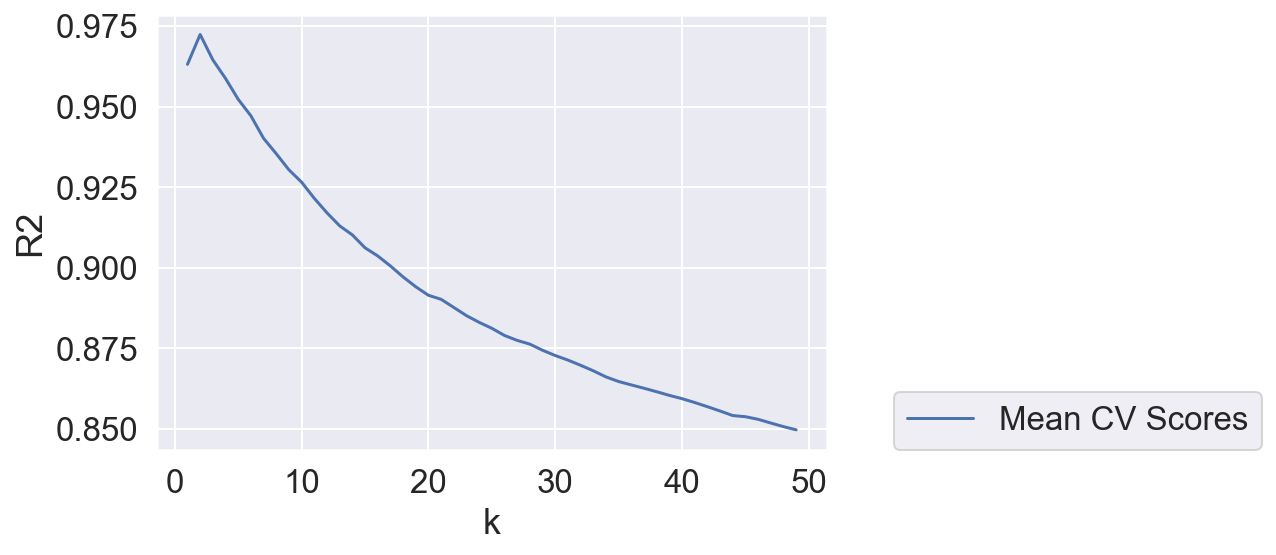

In [22]:
reg_model.knn_all_k()

In [8]:
reg_model.KNN_regressor(model=KNeighborsRegressor(2))

KNN Regression Model Test
Train Score: 0.9913 
CV Fold Score (r^2): 0.9683 
CV Fold Score (RMSE): 0.0113 
Model Test Score: No Test Set
Time Elapsed =  6.74 secs - grid will take ~ 6.74 minutes to run.



In [9]:
reg_model.VotingRegressor(vote_model1=KNeighborsRegressor(2))

Voting Regressor Model (default Linear & RF & GB) Test
Train Score: 0.9913 
CV Fold Score (r^2): 0.9516 
CV Fold Score (RMSE): 0.0139 
Model Test Score: No Test Set
Time Elapsed =  135.48 secs - grid will take ~ 135.48 minutes to run.



In [10]:
model_tracker.sort_values('cv_score_rmse')

,model_type,model_train_score,cv_score_r2,cv_score_rmse,test_score,predictors,model_params,observations,time,comment
1,KNN Regression Model,0.991274,0.968271,0.011262,No Test Set,"existence expectancy index,existence expectanc...",KNeighborsRegressor(n_neighbors=2),3865,6.742438,"3rd run with interpolation, no galaxy or year"
1,Voting Regressor Model (default Linear & RF & GB),0.991294,0.951585,0.013948,No Test Set,"existence expectancy index,existence expectanc...","VotingRegressor(estimators=[('gb', GradientBoo...",3865,135.484083,"3rd run with interpolation, no galaxy or year"
1,KNN Regression Model,0.977388,0.950871,0.013957,No Test Set,"existence expectancy index,existence expectanc...",KNeighborsRegressor(),3865,4.089656,"3rd run with interpolation, no galaxy or year"
1,Random Forest Model,0.991337,0.932284,0.016493,No Test Set,"existence expectancy index,existence expectanc...",RandomForestRegressor(random_state=66),3865,88.154868,"3rd run with interpolation, no galaxy or year"
1,Gradient Boosting Model,0.972783,0.910626,0.018947,No Test Set,"existence expectancy index,existence expectanc...",GradientBoostingRegressor(random_state=66),3865,39.471412,"3rd run with interpolation, no galaxy or year"
1,Voting Regressor Model (default Linear & RF & GB),0.954440,0.902686,0.019770,No Test Set,"existence expectancy index,existence expectanc...","VotingRegressor(estimators=[('gb', GradientBoo...",3865,135.363953,"3rd run with interpolation, no galaxy or year"
1,Decision Tree Model,1.000000,0.862776,0.023383,No Test Set,"existence expectancy index,existence expectanc...",DecisionTreeRegressor(random_state=66),3865,1.437238,"3rd run with interpolation, no galaxy or year"
14,KNN Regression Model,0.894570,0.815157,0.027242,No Test Set,"existence expectancy index,existence expectanc...",KNeighborsRegressor(),3865,3.573428,"Second run with imputed mean, no galaxy or year"
16,Random Forest Model,0.972292,0.787532,0.029194,No Test Set,"existence expectancy index,existence expectanc...",RandomForestRegressor(random_state=66),3865,36.421600,"Second run with imputed mean, no galaxy or year"
17,Gradient Boosting Model,0.893800,0.783238,0.029476,No Test Set,"existence expectancy index,existence expectanc...",GradientBoostingRegressor(random_state=66),3865,14.825497,"Second run with imputed mean, no galaxy or year"


In [11]:
model_tracker.to_csv("model_tracker.csv", index=False)